# 深层神经网络
前面一章我们简要介绍了神经网络的一些基本知识，同时也是示范了如何用神经网络构建一个复杂的非线性二分类器，更多的情况神经网络适合使用在更加复杂的情况，比如图像分类的问题，下面我们用深度学习的入门级数据集 MNIST 手写体分类来说明一下更深层神经网络的优良表现。

## MNIST 数据集
mnist 数据集是一个非常出名的数据集，基本上很多网络都将其作为一个测试的标准，其来自美国国家标准与技术研究所, National Institute of Standards and Technology (NIST)。 训练集 (training set) 由来自 250 个不同人手写的数字构成, 其中 50% 是高中学生, 50% 来自人口普查局 (the Census Bureau) 的工作人员，一共有 60000 张图片。 测试集(test set) 也是同样比例的手写数字数据，一共有 10000 张图片。

每张图片大小是 28 x 28 的灰度图，如下

![](https://ws3.sinaimg.cn/large/006tKfTcly1fmlx2wl5tqj30ge0au745.jpg)

所以我们的任务就是给出一张图片，我们希望区别出其到底属于 0 到 9 这 10 个数字中的哪一个。

## 多分类问题
前面我们讲过二分类问题，现在处理的问题更加复杂，是一个 10 分类问题，统称为多分类问题，对于多分类问题而言，我们的 loss 函数使用一个更加复杂的函数，叫交叉熵。

### softmax
提到交叉熵，我们先讲一下 softmax 函数，前面我们见过了 sigmoid 函数，如下

$$s(x) = \frac{1}{1 + e^{-x}}$$

可以将任何一个值转换到 0 ~ 1 之间，当然对于一个二分类问题，这样就足够了，因为对于二分类问题，如果不属于第一类，那么必定属于第二类，所以只需要用一个值来表示其属于其中一类概率，但是对于多分类问题，这样并不行，需要知道其属于每一类的概率，这个时候就需要 softmax 函数了。

softmax 函数示例如下

![](https://ws4.sinaimg.cn/large/006tKfTcly1fmlxtnfm4fj30ll0bnq3c.jpg)


对于网络的输出 $z_1, z_2, \cdots z_k$，我们首先对他们每个都取指数变成 $e^{z_1}, e^{z_2}, \cdots, e^{z_k}$，那么每一项都除以他们的求和，也就是

$$
z_i \rightarrow \frac{e^{z_i}}{\sum_{j=1}^{k} e^{z_j}}
$$

如果对经过 softmax 函数的所有项求和就等于 1，所以他们每一项都分别表示属于其中某一类的概率。

## 交叉熵
交叉熵衡量两个分布相似性的一种度量方式，前面讲的二分类问题的 loss 函数就是交叉熵的一种特殊情况，交叉熵的一般公式为

$$
cross\_entropy(p, q) = E_{p}[-\log q] = - \frac{1}{m} \sum_{x} p(x) \log q(x)
$$

对于二分类问题我们可以写成

$$
-\frac{1}{m} \sum_{i=1}^m (y^{i} \log sigmoid(x^{i}) + (1 - y^{i}) \log (1 - sigmoid(x^{i}))
$$

这就是我们之前讲的二分类问题的 loss，当时我们并没有解释原因，只是给出了公式，然后解释了其合理性，现在我们给出了公式去证明这样取 loss 函数是合理的

交叉熵是信息理论里面的内容，这里不再具体展开，更多的内容，可以看到下面的[链接](http://blog.csdn.net/rtygbwwwerr/article/details/50778098)

下面我们直接用 mnist 举例，讲一讲深度神经网络

In [1]:
import numpy as np
import torch
from torchvision.datasets import mnist # 导入 pytorch 内置的 mnist 数据

from torch import nn
from torch.autograd import Variable

In [2]:
# 使用内置函数下载 mnist 数据集
train_set = mnist.MNIST('./data', train=True, download=True)
test_set = mnist.MNIST('./data', train=False, download=True)

Processing...
Done!


我们可以看看其中的一个数据是什么样子的

In [3]:
a_data, a_label = train_set[0]

In [4]:
a_data

In [5]:
a_label

5

这里的读入的数据是 PIL 库中的格式，我们可以非常方便地将其转换为 numpy array

In [6]:
a_data = np.array(a_data, dtype='float32')
print(a_data.shape)

(28, 28)


这里我们可以看到这种图片的大小是 28 x 28

In [7]:
print(a_data)

[[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   3.  18.
   18.  18. 126. 136. 175.  26. 166. 255. 247. 127.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.  30.  36.  94. 154. 170. 253.
  253. 253. 253. 253. 225. 172. 253. 242. 195.  64.   0.  

我们可以将数组展示出来，里面的 0 就表示黑色，255 表示白色

对于神经网络，我们第一层的输入就是 28 x 28 = 784，所以必须将得到的数据我们做一个变换，使用 reshape 将他们拉平成一个一维向量

In [8]:
def data_tf(x):
    x = np.array(x, dtype='float32') / 255
    x = (x - 0.5) / 0.5 # 标准化，这个技巧之后会讲到
    x = x.reshape((-1,)) # 拉平
    x = torch.from_numpy(x)
    return x

train_set = mnist.MNIST('./data', train=True, transform=data_tf, download=True) # 重新载入数据集，申明定义的数据变换
test_set = mnist.MNIST('./data', train=False, transform=data_tf, download=True)

In [9]:
a, a_label = train_set[0]
print(a.shape)
print(a_label)

torch.Size([784])
5


In [10]:
from torch.utils.data import DataLoader
# 使用 pytorch 自带的 DataLoader 定义一个数据迭代器
train_data = DataLoader(train_set, batch_size=64, shuffle=True)
test_data = DataLoader(test_set, batch_size=128, shuffle=False)

使用这样的数据迭代器是非常有必要的，如果数据量太大，就无法一次将他们全部读入内存，所以需要使用 python 迭代器，每次生成一个批次的数据

In [11]:
a, a_label = next(iter(train_data))

In [12]:
# 打印出一个批次的数据大小
print(a.shape)
print(a_label.shape)

torch.Size([64, 784])
torch.Size([64])


In [26]:
# 使用 Sequential 定义 4 层神经网络
net = nn.Sequential(
    nn.Linear(784, 400),
    nn.ReLU(),
    nn.Linear(400, 200),
    nn.ReLU(),
    nn.Linear(200, 100),
    nn.ReLU(),
    nn.Linear(100, 10)
)

In [27]:
net

Sequential(
  (0): Linear(in_features=784, out_features=400)
  (1): ReLU()
  (2): Linear(in_features=400, out_features=200)
  (3): ReLU()
  (4): Linear(in_features=200, out_features=100)
  (5): ReLU()
  (6): Linear(in_features=100, out_features=10)
)

交叉熵在 pytorch 中已经内置了，交叉熵的数值稳定性更差，所以内置的函数已经帮我们解决了这个问题

In [28]:
# 定义 loss 函数
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), 1e-1) # 使用随机梯度下降，学习率 0.1

In [29]:
# 开始训练
losses = []
acces = []
eval_losses = []
eval_acces = []

for e in range(20):
    train_loss = 0
    train_acc = 0
    net.train()
    for im, label in train_data:
        im = Variable(im)
        label = Variable(label)
        # 前向传播
        out = net(im)
        loss = criterion(out, label)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 记录误差
        train_loss += loss.item()
        # 计算分类的准确率
        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / im.shape[0]
        train_acc += acc
        
    losses.append(train_loss / len(train_data))
    acces.append(train_acc / len(train_data))
    # 在测试集上检验效果
    eval_loss = 0
    eval_acc = 0
    net.eval() # 将模型改为预测模式
    for im, label in test_data:
        im = Variable(im)
        label = Variable(label)
        out = net(im)
        loss = criterion(out, label)
        # 记录误差
        eval_loss += loss.item()
        # 记录准确率
        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / im.shape[0]
        eval_acc += acc
        
    eval_losses.append(eval_loss / len(test_data))
    eval_acces.append(eval_acc / len(test_data))
    print('epoch: {}, Train Loss: {:.6f}, Train Acc: {:.6f}, Eval Loss: {:.6f}, Eval Acc: {:.6f}'
          .format(e, train_loss / len(train_data), train_acc / len(train_data), 
                     eval_loss / len(test_data), eval_acc / len(test_data)))

epoch: 0, Train Loss: 0.525527, Train Acc: 0.830690, Eval Loss: 0.214004, Eval Acc: 0.929292
epoch: 1, Train Loss: 0.169223, Train Acc: 0.948527, Eval Loss: 0.156571, Eval Acc: 0.951048
epoch: 2, Train Loss: 0.119509, Train Acc: 0.962537, Eval Loss: 0.141246, Eval Acc: 0.955301
epoch: 3, Train Loss: 0.093633, Train Acc: 0.970349, Eval Loss: 0.096926, Eval Acc: 0.970036
epoch: 4, Train Loss: 0.077827, Train Acc: 0.975413, Eval Loss: 0.088236, Eval Acc: 0.971025
epoch: 5, Train Loss: 0.062835, Train Acc: 0.980211, Eval Loss: 0.090155, Eval Acc: 0.973200
epoch: 6, Train Loss: 0.053678, Train Acc: 0.983109, Eval Loss: 0.084136, Eval Acc: 0.974189
epoch: 7, Train Loss: 0.056607, Train Acc: 0.982343, Eval Loss: 0.075727, Eval Acc: 0.976562
epoch: 8, Train Loss: 0.040552, Train Acc: 0.986774, Eval Loss: 0.065600, Eval Acc: 0.980024
epoch: 9, Train Loss: 0.034272, Train Acc: 0.989272, Eval Loss: 0.121962, Eval Acc: 0.963212
epoch: 10, Train Loss: 0.030490, Train Acc: 0.990005, Eval Loss: 0.067

画出 loss 曲线和 准确率曲线

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

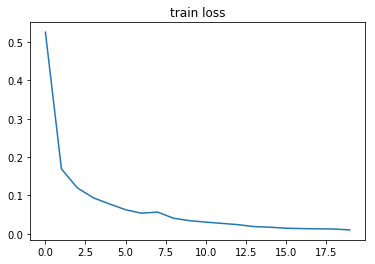

In [30]:
plt.title('train loss')
plt.plot(np.arange(len(losses)), losses)

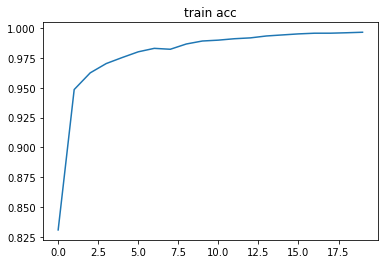

In [31]:
plt.plot(np.arange(len(acces)), acces)
plt.title('train acc')

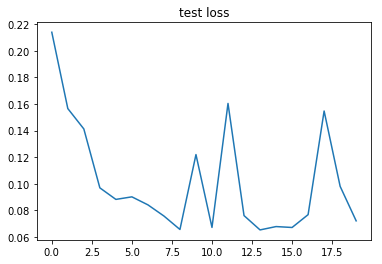

In [32]:
plt.plot(np.arange(len(eval_losses)), eval_losses)
plt.title('test loss')

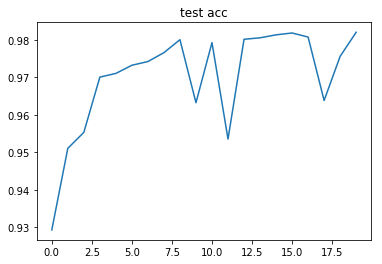

In [33]:
plt.plot(np.arange(len(eval_acces)), eval_acces)
plt.title('test acc')

可以看到我们的三层网络在训练集上能够达到 99.9% 的准确率，测试集上能够达到 98.20% 的准确率

**小练习：看一看上面的训练过程，看一下准确率是怎么计算出来的，特别注意 max 这个函数**

**自己重新实现一个新的网络，试试改变隐藏层的数目和激活函数，看看有什么新的结果**